In [1]:
import sys
sys.path.insert(0, '../')

# Datastores

In [2]:
import json
import os

from yuntu.datastore.base import Datastore
from yuntu.collection.base import Collection
from yuntu.core.annotation.annotation import Annotation

In [3]:
HOST = '<your_database_host>'
DATABASE = '<database_name>'
COLLECTION = '<collection_name>'
PATH_FIELD = '<field_with_path_information>'

DATASET = os.path.join(os.getcwd(), 'dataset.sqlite')
LABELLING_FILE = './formated_labelling_structure.json'

#### Annotation utils

In [4]:
def get_labelling_structure():
    with open(LABELLING_FILE, 'r') as jsonfile:
        return json.load(jsonfile)

## Datastore definition

In [5]:
from pymongo import MongoClient
from tqdm.notebook import tqdm


class LibChiroptera(Datastore):
    def __init__(self, base_dir=None):
        if base_dir is not None:
            self.base_dir = base_dir

        client = MongoClient(HOST)
        self.cursor = client[DATABASE][COLLECTION]
        self.labelling_structure = get_labelling_structure()
        self.query = {
            "notes": {"$not": {"$size": 0}},
            "mexican_species": True,
            "media_collection": {"$ne": "UNAM-ULM"}
        }
        self.projection = {
            "lustre_path": 1,
            "origmd": 1,
            "notes_size": 1,
            "media_collection": 1,
            "timeexp": 1,
            "geom": 1,
            "md5": 1,
            "ready": 1,
            "species": 1,
            "country": 1,
            "meta_id": 1,
            "former_species": 1,
            "owner": 1,
            "media_info": 1,
            "notes": 1,
            "geom": 1
        }

    def iter(self):
        total = self.cursor.count_documents(self.query)
        query = self.cursor.find(self.query, self.projection)
        for document in tqdm(query, total=total):
            samplerate = document['media_info']['samplerate']
            timeexp = document['timeexp']
            if samplerate * timeexp < 50000:
                continue

            yield document

    def iter_annotations(self, datum):
        for note in datum['notes']:
            if 'line' not in note['noteType']:
                continue

            yield note

    def prepare_datum(self, datum):
        path = os.path.basename(datum.get(PATH_FIELD)[1:])
        document_id = str(datum.get('_id'))
        hash_str = datum.get('md5')
        timeexp = datum.get('timeexp')
        spectrum = 'ultrasonic'
        media_info = datum.get('media_info')

        datum['_id'] = str(datum['_id'])
        datum['meta_id'] = str(datum['meta_id'])

        if 'parent_id' in datum:
            datum['parent_id'] = str(datum['parent_id'])

        if 'user' in datum['origmd']:
            datum['origmd']['user']['_id'] = str(datum['origmd']['user']['_id'])

        return {
            'path': path,
            'hash': hash_str,
            'timeexp': float(timeexp),
            'spectrum': spectrum,
            'media_info': media_info,
            'metadata': datum
        }

    def prepare_annotation(self, datum, annotation):
        timeexp = datum['timeexp']
        species = annotation["species"]
        vertices = [
            [x[0] / timeexp, 1000 * x[1] * timeexp]
            for x in annotation["rverts"]]
        wkt = 'LINESTRING(%s)' % ','.join([f'{x[0]} {x[1]}' for x in vertices])

        return {
            "labels": self.labelling_structure[species],
            "type": Annotation.Types.LINESTRING.value,
            "start_time": annotation["startTime"] / timeexp,
            "end_time": annotation["endTime"] / timeexp,
            "max_freq": annotation["maxFreq"] * timeexp,
            "min_freq": annotation["minFreq"] * timeexp,
            "geometry": wkt,
            "metadata": annotation
        }

# Collections

### Create a new collection

In [4]:
db_config = {
    'provider': 'sqlite',
    'config': {
        'filename': DATASET,
        'create_db': True
    }
}

In [5]:
collection = Collection(db_config)

### Create the datastore

Suppose the files are mounted at

In [4]:
MOUNT_DIR = os.path.expanduser('~/mount/')

In [5]:
datastore = LibChiroptera(base_dir=MOUNT_DIR)

NameError: name 'LibChiroptera' is not defined

### Insert into collection

In [10]:
datastore.insert_into(collection)

### Get a single recording

In [8]:
audio = collection.get(1)

#### Check its annotations

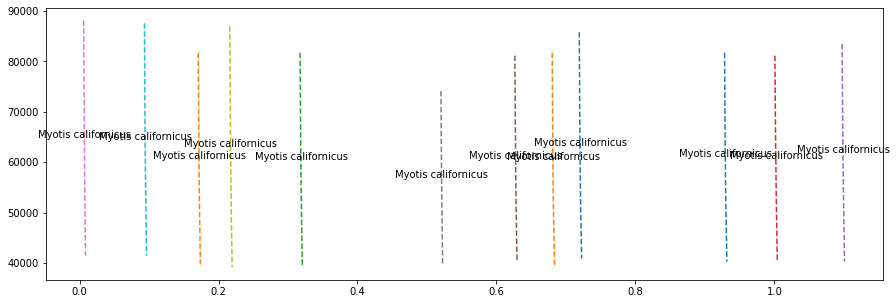

In [9]:
audio.annotations.plot(label=True, key='species')

In [10]:
annotation = audio.annotations[0]

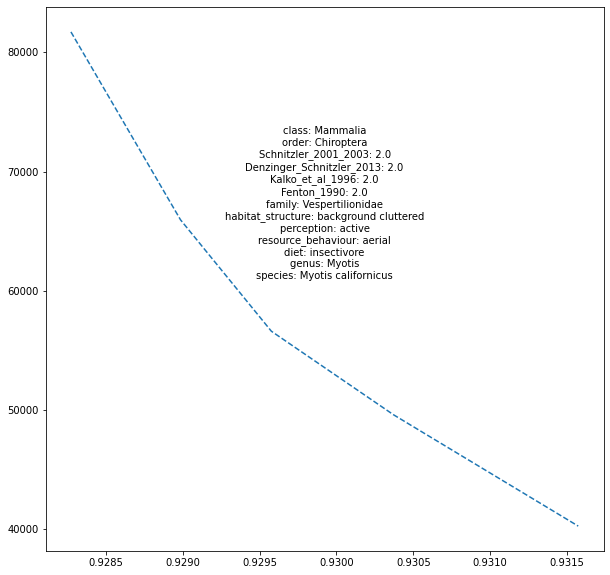

In [11]:
annotation.plot(label=True)

#### Cast annotation into other annotation types

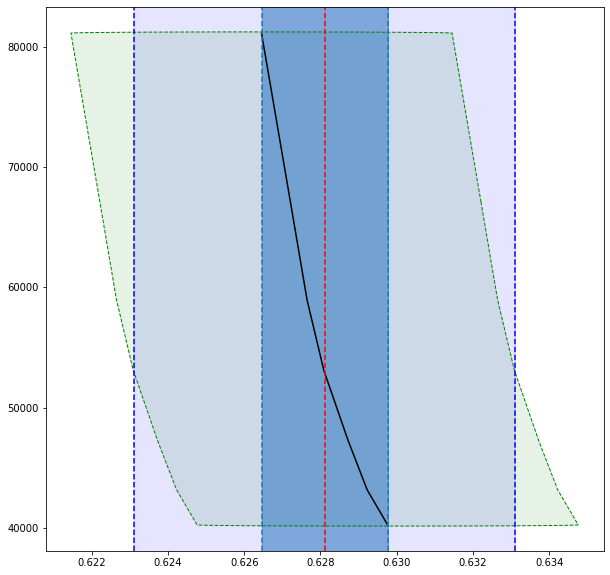

In [15]:
ax = annotation.plot(color='black', linestyle='-')
annotation.buffer(time=0.005, freq=100).plot(ax=ax, color='green', alpha=0.1)
annotation.to_time_interval().plot(ax=ax)
annotation.to_time_interval().to_center_line().plot(ax=ax, color='red')
annotation.to_time_interval().to_center_line().buffer(time=0.005).plot(ax=ax, color='blue', alpha=0.1)

### Recordings Dataframe

In [4]:
db_config = {
    'provider': 'sqlite',
    'config': {
        'filename': DATASET,
        'create_db': True
    }
}
collection = Collection(db_config)

In [5]:
df = collection.get_recording_dataframe(limit=10)

In [6]:
df.audio[:3]

[Audio(path='/Users/erobredo/mount/5aa403e95d5b148aa6138945.WAV', duration=1.2809666666666666, samplerate=300000),
 Audio(path='/Users/erobredo/mount/5aa403e95d5b148aa6138946.WAV', duration=4.525596666666667, samplerate=300000),
 Audio(path='/Users/erobredo/mount/5aa403e95d5b148aa6138947.WAV', duration=5.08356, samplerate=300000)]

In [7]:
ann = collection.get_annotation_dataframe(limit=10)

In [8]:
ann

,id,recording,type,metadata,start_time,end_time,max_freq,min_freq,geometry,labels,...,Denzinger_Schnitzler_2013,Kalko_et_al_1996,Fenton_1990,family,habitat_structure,perception,resource_behaviour,diet,genus,species
0,1,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:49:30', 'author': '...",1.097331,1.100885,83.463035,40.272374,LINESTRING(1.0973310864708397 83463.0350194552...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
1,2,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:43:40', 'author': '...",0.216231,0.219603,86.964981,39.105058,LINESTRING(0.2162308619422162 86964.9805447470...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
2,3,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:45:45', 'author': '...",0.680178,0.683607,81.712062,39.105058,LINESTRING(0.680178045385667 81712.06225680932...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
3,4,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:44:44', 'author': '...",0.317409,0.320667,81.712062,39.105058,LINESTRING(0.31740897494586856 81712.062256809...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
4,5,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:44:24', 'author': '...",0.005893,0.008606,88.132296,41.439689,LINESTRING(0.005892688153242415 88132.29571984...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
5,6,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:44:03', 'author': '...",0.093439,0.096467,87.548638,41.439689,LINESTRING(0.09343909185617098 87548.638132295...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
6,7,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:47:27', 'author': '...",0.928274,0.931572,81.712062,40.272374,LINESTRING(0.9282737972568676 81712.0622568093...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
7,8,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:48:40', 'author': '...",1.000732,1.004110,81.128405,40.272374,"LINESTRING(1.000732253856316 81128.4046692607,...","[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
8,9,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:45:03', 'author': '...",0.520109,0.522556,74.124514,39.688716,LINESTRING(0.5201091326777508 74124.5136186770...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
9,10,1,LineStringAnnotation,"{'actDate': '01-12-2018,00:46:04', 'author': '...",0.719162,0.722503,85.797665,40.856031,LINESTRING(0.7191622058245645 85797.6653696498...,"[{'key': 'class', 'type': 'taxonomic', 'value'...",...,2.0,2.0,2.0,Vespertilionidae,background cluttered,active,aerial,insectivore,Myotis,Myotis californicus
